<a href="https://colab.research.google.com/github/nim17/Flipkart-mobile-price-/blob/master/GPT_top_5_words_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from os import listdir
mypath="/content/"
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#onlyfiles = [f for f in onlyfiles if f.split('.')[-1]=='htm']
onlyfiles

['topicfooter.htm',
 'useful_links.htm',
 'Company_Sick_Pay.htm',
 'Equal_Opportunities.htm',
 'topic_list.htm',
 'topicfooterDark.htm',
 'html5.png',
 'outputs_mobile_apps.htm',
 'variables.htm',
 'Dependants_Leave.htm',
 'Health_and_Safety.htm',
 'Disciplinary_Procedure.htm',
 'Bookings.htm',
 'dropdowns.htm',
 'scripts.htm',
 'contents_panel.htm',
 'snippets.htm',
 'outputs_ebook.htm',
 'outputs_xml.htm',
 'homepagefooterDark.htm',
 'resource_linking.htm',
 'skin_editor.htm',
 'toc.htm',
 'topic.htm',
 'upgrading_to_2019.htm',
 'browse_sequences.htm',
 'dynamic_content.htm',
 'Topic_One.htm',
 'master_pages.htm',
 'find_and_replace.htm',
 'reports.htm',
 'single_sourcing.htm',
 'outputs_frameless.htm',
 'command_line.htm',
 'outputs_pdf.htm',
 'glossary.htm',
 'homepagefooter.htm',
 'outputs_word.htm',
 'Attendance.htm',
 'outputs_general.htm',
 'robohelp_reimagined.htm',
 'New_Topic1.htm',
 'index.htm',
 'Flexible_Working.htm',
 'merged_help.htm',
 'search.htm',
 'Harassment.htm',


In [0]:
path="/content/"

f=open(f'{path}Attendance.htm')
from bs4 import BeautifulSoup
"""soup=BeautifulSoup(text)
for hit in soup.findAll('body'):
    print (hit.text)"""
#print(text)
only_files=onlyfiles[3:]
text_list=[]
i=0
for t in onlyfiles:
    p=path+t
   # print(p)
    f = open(f"{p}", "r")
    try:
        text=f.read()
        soup=BeautifulSoup(text)
        text=[hit.text for hit in soup.findAll('body')]
        text="".join(text)
        text_list.append(text)
    except UnicodeDecodeError:
        i+=1
        print(i)    
text_list[0]

1


'\n\n\n\n\nEN\n\n\n\n\n\nContact Us\n\n\nPrivacy Policy\n\n\nTerms and Conditions\n\n\nBlog\n\n\n\n'

In [0]:
def prep(text):
    esc=['\n','\r','\t','\b','\f','\ooo','\h',"\'"]
    text=text.replace("\n"," ")
    text=[t for t in text if t not in esc]
    text=''.join(text)
    text=" ".join(text.split())
    text=text.replace('Â ', '')
    text=text.split(".")[2:]
    text=". ".join(text)
    return text
text=[prep(t) for t in text_list]

In [0]:
text_list=text.copy()
len(text_list)

77

In [30]:
import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
import time
from matplotlib import pyplot as plt
total_matches=0
total_length=0
accuracy_list=[]
times_list=[]
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
# import logging
# logging.basicConfig(level=logging.INFO)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
# Encode a text inputs
# text = "Who was Jim Henson? Jim Henson was a man"
# text = "Delete this text and replace it with your"
right_confidence=[]
wrong_confidence=[]
correct_words=[]
j=0
for t in text_list:
    text = t
    j+=1
    #if j==3:
    #  break
    indexed_tokens = tokenizer.encode(text)


    # Convert indexed tokens in a PyTorch tensor
    tokens_tensor = torch.tensor([indexed_tokens])
    input_tensor = tokens_tensor[:,:-1]
    output_tensor = tokens_tensor[:,1:]
    # print("input,output: ",tokens_tensor, input_tensor)
    

    # Set the model in evaluation mode to deactivate the DropOut modules
    # This is IMPORTANT to have reproducible results during evaluation!
    model.eval()
    matches = 0
    no_match=0
    length=0
    # If you have a GPU, put everything on cuda
    #tokens_tensor = tokens_tensor.to('cuda')
    #model.to('cuda')
    length=len(input_tensor[0])
    print("Sentence Length = ",length)
        
    times_array = []
    i=2
    while(i<len(input_tensor[0])+1):
    #for i in range(2,len(input_tensor[0])+1):
        if i>=len(input_tensor[0]):
              break
        token=tokenizer.decode(input_tensor[0][i].reshape(1,1))
        if token=='.':
            i+=4
            if i>=len(input_tensor[0]):
              break
            continue
        start_time = time.time()
        # Predict all tokens
        with torch.no_grad():
    #         print("input shape", input_tensor[0][:i].shape)
            if(i<100):
                outputs = model(input_tensor[:,:i])
            else:
                outputs = model(input_tensor[:,i-100:i])
            predictions = outputs[0]
    #         print("output shape", predictions.shape)
            predicted_index = torch.argmax(predictions[0, -1, :]).item()
            arr=np.array(predictions[0, -1, :])
            arr=arr.argsort()[-5:][::-1]
    #         print("predicted index: ", predicted_index)
            confidence=torch.max(predictions[0, -1, :]).item()
            if(int(tokens_tensor[0][i]) in arr):
                matches+=1
                right_confidence.append(confidence)
                correct_words.append(tokenizer.decode([predicted_index]))
            else:
                wrong_confidence.append(confidence)
                no_match+=1
                #predicted_text = tokenizer.decode([predicted_index])
                #print('confidence= ',confidence)
                #print("predicted text", predicted_text)
            elapsed = time.time() - start_time
            times_array.append(elapsed)
            predicted_text = tokenizer.decode([predicted_index])
        print(i,end=" ")
        i+=1
    #         print(i,"given: ",tokenizer.decode(list(input_tensor[0][:i])), ", predicted: ", predicted_text, ", time: ", elapsed)
    total_matches+=matches
    total_length+=no_match+matches
    if matches+no_match >0:
      accuracy=matches/(matches+no_match)
      print("file name: ",onlyfiles[j-1]," matches= ",matches,"\taccuracy=",accuracy)
      accuracy_list.append(accuracy)
    times_list.append(times_array)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


Sentence Length =  0
Sentence Length =  151
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 31 36 41 42 43 44 45 46 47 48 49 50 51 52 53 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 81 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

Token indices sequence length is longer than the specified maximum sequence length for this model (1375 > 512). Running this sequence through the model will result in indexing errors


150 file name:  useful_links.htm  matches=  36 	accuracy= 0.2975206611570248
Sentence Length =  1374
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 173 174 175 176 177 178 179 180 181 186 187 188 189 190 191 192 193 194 195 196 197 198 199 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 2

Token indices sequence length is longer than the specified maximum sequence length for this model (1204 > 512). Running this sequence through the model will result in indexing errors


1372 file name:  Company_Sick_Pay.htm  matches=  652 	accuracy= 0.553011026293469
Sentence Length =  1203
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 88 89 90 91 92 93 94 95 96 97 98 99 100 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 127 128 129 130 131 132 133 134 135 136 137 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 235 236 237 238 239 240 241 242 243 244 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 270 271 272 273 274 275 276 277 278 279 280 285 286 287 288 289 290 291 292 293 294 295 296 

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


219 file name:  html5.png  matches=  87 	accuracy= 0.4887640449438202
Sentence Length =  515
2 3 4 5 6 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 54 55 56 57 58 59 60 61 62 63 64 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 94 95 96 97 98 99 100 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130 131 132 133 134 135 136 137 138 139 140 141 146 147 148 149 154 155 156 157 158 159 160 161 162 163 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 288 289 290 291 292 293 294 295 296 297 298 303 304 305 306 307 308 30

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


514 file name:  outputs_mobile_apps.htm  matches=  195 	accuracy= 0.4721549636803874
Sentence Length =  565
2 3 4 5 6 7 8 9 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 78 79 80 81 82 83 84 85 86 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 217 218 219 220 221 222 223 224 225 226 227 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 253 254 255 256 257 258 259 260 261 262 263 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 28

Token indices sequence length is longer than the specified maximum sequence length for this model (1235 > 512). Running this sequence through the model will result in indexing errors


564 file name:  variables.htm  matches=  216 	accuracy= 0.4585987261146497
Sentence Length =  1234
2 3 4 5 6 7 8 9 10 11 16 17 18 19 20 21 26 27 28 29 30 31 32 33 34 35 36 37 38 39 44 45 46 47 48 49 50 51 52 53 54 55 60 61 62 63 64 65 66 67 68 69 70 75 76 77 78 79 80 81 82 83 84 85 86 87 88 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 250 251 252 253 254 255 256 257 258 259 260 261 266 267 268 269 270 271 272 273 274 275 276 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299

Token indices sequence length is longer than the specified maximum sequence length for this model (1356 > 512). Running this sequence through the model will result in indexing errors


1232 file name:  Dependants_Leave.htm  matches=  501 	accuracy= 0.5075987841945289
Sentence Length =  1355
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 27 32 33 34 35 36 37 38 39 40 41 42 43 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 172 173 174 175 176 177 178 179 180 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 226 227 228 229 230 231 232 233 234 235 236 237 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 281 282 283 284 285 286 287 288 289 290 291

Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


323 file name:  dropdowns.htm  matches=  116 	accuracy= 0.44274809160305345
Sentence Length =  656
2 3 4 5 6 7 12 13 14 15 16 17 18 19 20 21 22 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 74 75 76 77 78 79 80 81 82 83 84 89 90 91 92 93 94 95 100 101 102 103 104 105 106 107 108 109 110 111 112 113 118 119 120 121 122 123 124 125 126 127 128 129 130 131 136 137 138 139 140 141 142 143 144 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 168 169 170 171 172 173 174 175 176 177 178 179 184 185 186 187 188 189 190 191 192 193 194 199 200 201 202 203 204 205 210 211 212 213 214 215 216 221 222 223 224 225 226 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 307 308 309 310 311 312 313 314 315 316 317 322 3

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors


303 file name:  homepagefooterDark.htm  matches=  107 	accuracy= 0.4349593495934959
Sentence Length =  732
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 94 95 96 97 98 99 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 210 211 212 213 214 215 216 217 222 223 224 225 226 227 228 229 230 231 232 233 234 235 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 294 295 296 297 298 299

Token indices sequence length is longer than the specified maximum sequence length for this model (1169 > 512). Running this sequence through the model will result in indexing errors


731 file name:  resource_linking.htm  matches=  293 	accuracy= 0.4899665551839465
Sentence Length =  1168
2 3 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 70 71 72 73 74 75 76 77 78 79 80 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 143 144 145 146 147 148 149 150 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 206 207 208 209 210 211 212 213 214 215 216 217 218 219 224 225 226 227 228 229 230 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 303 

Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors


65 file name:  upgrading_to_2019.htm  matches=  23 	accuracy= 0.4107142857142857
Sentence Length =  850
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 48 49 50 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 80 81 82 83 84 85 86 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 182 183 184 185 186 187 188 189 190 191 192 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 274 275 276 277 278 279 280 281 282 283 284 285 290 291 292 293 294 295 29

Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


13 14 file name:  find_and_replace.htm  matches=  4 	accuracy= 0.3076923076923077
Sentence Length =  585
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 31 32 33 34 35 36 37 38 39 40 41 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 85 86 87 88 89 90 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 115 116 117 118 119 120 121 126 127 128 129 130 131 132 133 134 135 136 137 142 143 144 145 146 147 152 153 154 155 156 157 158 159 160 161 162 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 219 220 221 222 223 224 225 226 227 232 233 234 235 236 237 238 239 240 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 286 287 288 289 290 291 292 293 294 295 296 297 298 303 304 305 306 307 308 309 314 315 316 317 318 3

Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors


584 file name:  reports.htm  matches=  205 	accuracy= 0.4279749478079332
Sentence Length =  704
2 3 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49 50 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 102 103 104 105 106 107 108 109 110 111 112 113 114 119 120 121 122 123 128 129 130 131 132 133 134 135 136 137 138 139 140 141 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 168 169 170 171 172 173 174 179 180 181 182 183 188 189 190 191 192 193 194 195 196 197 198 199 200 205 206 207 208 209 210 211 212 213 214 215 216 217 222 223 224 225 226 227 228 229 230 231 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 317 

Token indices sequence length is longer than the specified maximum sequence length for this model (1245 > 512). Running this sequence through the model will result in indexing errors


396 file name:  outputs_frameless.htm  matches=  138 	accuracy= 0.43260188087774293
Sentence Length =  1244
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 169 170 171 172 173 174 175 176 181 182 183 184 185 190 191 192 193 194 195 196 197 198 199 200 201 206 207 208 209 210 211 212 213 214 215 216 217 218 219 224 225 226 227 228 229 230 231 232 233 234 235 240 241 242 243 244 245 246 247 248 249 250 251 252 253 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 29

Token indices sequence length is longer than the specified maximum sequence length for this model (1093 > 512). Running this sequence through the model will result in indexing errors


297 file name:  outputs_pdf.htm  matches=  139 	accuracy= 0.54296875
Sentence Length =  0
Sentence Length =  1092
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 86 87 88 89 90 91 92 93 98 99 100 101 102 107 108 109 110 111 112 113 114 115 116 117 118 123 124 125 126 127 128 129 130 131 132 133 134 135 136 141 142 143 144 145 146 147 148 149 150 155 156 157 158 159 160 161 162 163 164 165 166 167 168 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 242 243 244 245 246 247 248 253 254 255 256 257 258 259 260 261 262 263 264 265 266 271 272 273 274 275 276 277 278 279 280 281 282 283 288 289 290 291 292 293 294 295 296 297 298 299 300 301 

Token indices sequence length is longer than the specified maximum sequence length for this model (741 > 512). Running this sequence through the model will result in indexing errors


1091 file name:  homepagefooter.htm  matches=  439 	accuracy= 0.5
Sentence Length =  740
2 3 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 45 46 47 48 49 50 51 52 53 54 55 56 57 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 210 211 212 213 214 215 216 217 218 219 220 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 2

Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors


738 file name:  outputs_word.htm  matches=  297 	accuracy= 0.4813614262560778
Sentence Length =  594
2 3 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 67 68 69 70 71 72 73 74 75 76 77 78 79 84 85 86 87 88 89 90 91 92 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 185 186 187 188 189 190 191 192 193 194 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 225 226 227 228 229 230 231 232 233 234 235 236 237 242 247 248 249 250 251 256 257 258 259 260 261 262 263 264 269 270 271 272 273 274 275 276 277 278 279 280 281 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 307 308 309 310 311 3

Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors


593 file name:  Attendance.htm  matches=  201 	accuracy= 0.42948717948717946
Sentence Length =  701
2 3 4 5 6 7 8 9 10 11 12 13 14 19 20 21 22 23 24 25 26 27 28 29 30 35 36 37 38 39 40 41 42 43 44 45 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 135 136 137 138 139 140 145 146 147 148 149 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 185 186 187 188 189 190 191 192 193 194 195 196 197 198 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 287 288 289 290 291 292 293 294 295 300 301 302 303 308 309 310 311 31

Token indices sequence length is longer than the specified maximum sequence length for this model (1804 > 512). Running this sequence through the model will result in indexing errors


700 file name:  outputs_general.htm  matches=  244 	accuracy= 0.44283121597096187
Sentence Length =  0
Sentence Length =  0
Sentence Length =  1803
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 62 63 64 65 66 67 68 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 26

Token indices sequence length is longer than the specified maximum sequence length for this model (1028 > 512). Running this sequence through the model will result in indexing errors


115 file name:  New_Topic.htm  matches=  30 	accuracy= 0.40540540540540543
Sentence Length =  1027
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 71 72 73 74 75 76 77 78 79 80 81 86 87 88 89 90 91 92 97 98 99 100 101 106 107 108 109 110 111 112 113 114 115 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 169 170 171 172 173 174 175 176 177 178 179 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 227 228 229 230 231 232 233 234 239 240 245 246 247 248 249 254 255 256 257 258 259 260 261 266 267 268 269 270 271 272 273 274 275 276 277 278 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 321 322 323 324

Token indices sequence length is longer than the specified maximum sequence length for this model (942 > 512). Running this sequence through the model will result in indexing errors


476 file name:  tables.htm  matches=  162 	accuracy= 0.4366576819407008
Sentence Length =  941
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 24 25 26 27 28 29 30 31 32 33 34 35 36 37 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 181 182 183 188 189 190 191 192 193 194 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 254 255 256 257 258 259 260 265 266 267 268 269 270 271 272 273 274 275 276 277 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 303 304 305 306 3

Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors


940 file name:  ui.htm  matches=  321 	accuracy= 0.4099616858237548
Sentence Length =  723
2 3 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 45 46 47 48 49 50 51 52 53 54 55 56 57 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 276 277 278 279 280 285 286 287 288 289 290 291 292 293 294 295 296

Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


197 file name:  Attendance_e_Book.htm  matches=  73 	accuracy= 0.45625
Sentence Length =  717
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 27 28 29 34 35 36 37 38 39 40 41 42 43 44 45 46 47 52 53 54 55 56 57 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 83 84 85 86 87 88 89 90 91 92 93 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 142 143 144 145 146 147 148 149 150 151 152 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 178 179 180 181 182 183 184 185 186 187 188 189 190 191 196 197 198 199 200 201 202 207 208 209 210 211 212 213 214 215 216 217 218 219 224 225 226 227 228 229 230 231 232 233 234 235 240 241 242 243 244 245 246 247 248 249 254 255 256 257 258 259 264 265 266 267 268 269 270 271 272 277 278 279 280 281 282 283 284 285 286 287 288 289 294 295 296 297 298 299 300 301 302 307 308 309 310 311 312 313 314 315 316 317 318 323 324 325 326 327 332 

Token indices sequence length is longer than the specified maximum sequence length for this model (1031 > 512). Running this sequence through the model will result in indexing errors


716 file name:  outputs_responsive.htm  matches=  254 	accuracy= 0.45765765765765765
Sentence Length =  1030
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 154 155 156 157 158 159 160 161 162 163 164 165 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 210 211 212 213 214 215 216 221 222 223 224 225 226 227 228 229 230 231 232 233 234 239 240 241 242 243 244 249 250 251 252 253 254 259 260 261 262 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 3

Token indices sequence length is longer than the specified maximum sequence length for this model (1108 > 512). Running this sequence through the model will result in indexing errors


374 file name:  mapping.htm  matches=  135 	accuracy= 0.42586750788643535
Sentence Length =  1107
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 26 27 28 29 30 31 32 33 34 35 36 37 38 39 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 91 92 93 94 95 96 97 98 99 100 101 102 107 108 109 110 111 112 113 114 115 116 117 118 119 120 125 126 127 128 129 130 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 162 163 164 165 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 200 201 202 203 204 205 206 207 208 213 214 215 216 217 218 219 220 225 226 227 228 229 230 231 232 237 238 239 240 241 242 243 244 245 250 251 252 253 254 255 256 257 258 259 260 265 266 267 268 269 270 271 272 273 274 275 276 281 282 283 284 285 286 287 288 289 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 

Token indices sequence length is longer than the specified maximum sequence length for this model (2078 > 512). Running this sequence through the model will result in indexing errors


349 file name:  see_also_and_related.htm  matches=  138 	accuracy= 0.5073529411764706
Sentence Length =  2077
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 37 42 43 44 45 46 47 48 49 50 51 52 53 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 138 139 140 141 142 143 148 149 150 151 152 153 154 155 156 157 162 163 164 169 170 171 172 173 174 175 176 177 178 179 180 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 213 214 215 216 217 218 219 220 221 222 223 224 225 226 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 261 262 267 268 269 270 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 

Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors


2076 file name:  publishing.htm  matches=  757 	accuracy= 0.4508636092912448
Sentence Length =  1090
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 195 196 197 198 199 200 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 275 276 277 278 279 280 281 282 283 284 285 286 2

Token indices sequence length is longer than the specified maximum sequence length for this model (1336 > 512). Running this sequence through the model will result in indexing errors


378 file name:  outputs_chm.htm  matches=  116 	accuracy= 0.4070175438596491
Sentence Length =  1335
2 3 4 5 6 7 8 9 10 11 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 53 54 55 56 57 58 59 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 138 139 140 141 142 143 144 145 146 147 148 149 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 174 175 176 177 178 179 180 185 186 187 188 189 190 191 192 193 194 199 200 201 202 203 204 205 206 207 208 209 210 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 262 263 264 265 266 267 268 269 270 275 276 277 278 279 280 281 282 283 284 285 286 287 288 293 294 295 296 297 298 299 300 301 306 307 308 309 310 315 316 3

In [53]:
def averageOfList(num):
    sumOfNumbers = 0
    for t in num:
        sumOfNumbers = sumOfNumbers + t

    avg = sumOfNumbers / len(num)
    return avg
averageOfList(accuracy_list)

0.4903735250078722

In [54]:
max(accuracy_list)

0.8023255813953488

In [55]:
min(accuracy_list)

0.2975206611570248

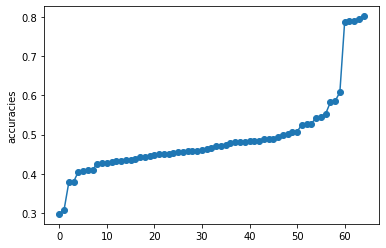

In [56]:
import matplotlib.pyplot as plt

plt.plot(accuracy_list)
plt.scatter(range(len(accuracy_list)),accuracy_list)
plt.ylabel('accuracies')
plt.show()

In [0]:
accuracy_list.sort()

In [57]:
accuracy_list

[0.2975206611570248,
 0.3076923076923077,
 0.3779527559055118,
 0.3793103448275862,
 0.40540540540540543,
 0.4070175438596491,
 0.4099616858237548,
 0.4107142857142857,
 0.42586750788643535,
 0.4262948207171315,
 0.4279749478079332,
 0.42948717948717946,
 0.43260188087774293,
 0.43312101910828027,
 0.4349593495934959,
 0.43636363636363634,
 0.4366576819407008,
 0.44274809160305345,
 0.44283121597096187,
 0.44545454545454544,
 0.4474708171206226,
 0.44950738916256155,
 0.4508636092912448,
 0.45126353790613716,
 0.45294117647058824,
 0.45567206863679693,
 0.45625,
 0.45765765765765765,
 0.4585987261146497,
 0.459037711313394,
 0.46153846153846156,
 0.4630681818181818,
 0.4653179190751445,
 0.47058823529411764,
 0.4721549636803874,
 0.4735099337748344,
 0.4780652418447694,
 0.48125,
 0.4813614262560778,
 0.4822485207100592,
 0.48328267477203646,
 0.48427672955974843,
 0.4846153846153846,
 0.48812664907651715,
 0.4887640449438202,
 0.4899665551839465,
 0.49337748344370863,
 0.5,
 0.5015105